### Country Leave One Out

Here we are doing a `leave-one-out` analysis on country. I have copied much from elsewhere, as I anticipate expanding this to other fields once I have it working, and so we ca use the same data frames, etc.

In [1]:
# some of these are not needed!
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import seaborn as sns
import numpy as np


import math
import re

from scipy.stats import pearsonr, f_oneway, mode
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import decomposition, metrics
from sklearn.ensemble import RandomForestClassifier


import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, tukeyhsd, MultiComparison
from statsmodels.multivariate.manova import MANOVA

from PhiSpyAnalysis import theils_u, DateConverter


import subprocess
import gzip


In [2]:
use_small_data = False
if use_small_data:
    phagesdf = pd.read_csv("../small_data/phages_per_genome.tsv.gz", compression='gzip', header=0, delimiter="\t")
else:
    phagesdf = pd.read_csv("../data/phages_per_genome.tsv.gz", compression='gzip', header=0, delimiter="\t")
githash = subprocess.check_output(["git", "describe", "--always"]).strip().decode()
print(f"Please note that this was run with git commit {githash} that has {phagesdf.shape[0]:,} genomes parsed and {phagesdf['Total Predicted Prophages'].sum():,} total prophages")

Please note that this was run with git commit 65b06cc that has 553,082 genomes parsed and 20,946,107 total prophages


### The assembly accession ID column

PATRIC calls the column `assembly_accession` while GTDB calls it `ncbi_genbank_assembly_accession`

In [3]:
acccol = 'assembly_accession'

In [4]:
def get_acc_name(x):
    regexp = re.compile('(\w+\.\d+)_([\w\.\-]+)_genomic.gbff.gz')
    m = regexp.match(x)
    if not m:
        sys.stderr.write(f"WARNING: Regexp did not match {x}\n")
        return (None, None)
    return list(m.groups())

phagesdf = pd.concat([pd.DataFrame.from_records(phagesdf['Contig'].apply(get_acc_name), columns=[acccol, 'Name']), phagesdf['Kept']], axis=1)
phagesdf = phagesdf.drop('Name', axis=1)
phagesdf

,assembly_accession,Kept
0,GCA_000003135.1,2
1,GCA_000003645.1,1
2,GCA_000003925.1,6
3,GCA_000003955.1,6
4,GCA_000005825.2,3
...,...,...
553077,GCA_902860175.1,2
553078,GCA_902860185.1,0
553079,GCA_902860195.1,1
553080,GCA_902860205.1,2


In [5]:
if use_small_data:
    metadf = pd.read_csv("../small_data/patric_genome_metadata.tsv.gz", compression='gzip', header=0, delimiter="\t")
else:
    metadf = pd.read_csv("../data/patric_genome_metadata.tsv.gz", compression='gzip', header=0, delimiter="\t")
dc = DateConverter()
metadf['isolation_date'] = metadf.collection_date.apply(dc.convert_date)

/home/redwards/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2,6,7,8,9,10,11,12,14,19,21,34,40,41,42,43,44,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,65) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Filter for only the first of each genome assembly

The metadata contains multiple entries for a genome assembly if it is submitted more than once, so here we just filter for the first instance. We might think about something smarter,  but this seems to work

In [6]:
metadf = metadf.groupby('assembly_accession').first().reset_index()

## Clean up the data

These are specific things in the data that we need to clean/replace.

In [7]:
metadf['isolation_country'] = metadf['isolation_country'].replace('USA', 'United States')
metadf['isolation_country'] = metadf['isolation_country'].replace('Ecully', 'France')
metadf['geographic_location'] = metadf['geographic_location'].replace('USA', 'United States')
metadf['isolation_country'] = metadf['isolation_country'].replace('Adriatic Sea coasts', 'Adriatic Sea')
metadf['isolation_country'] = metadf['isolation_country'].replace('Côte', "Cote d'Ivoire")
metadf['isolation_country'] = metadf['isolation_country'].replace('" Azores"', 'Azores')
metadf['isolation_country'] = metadf['isolation_country'].replace('Democratic Republic of the Congo (Kinshasa)', 'Democratic Republic of the Congo')
metadf['isolation_country'] = metadf['isolation_country'].replace('Hong kong', 'Hong Kong')
metadf['isolation_country'] = metadf['isolation_country'].replace(' Republic of Korea', 'Republic of Korea')
metadf['isolation_country'] = metadf['isolation_country'].replace('Soviet Union', 'USSR')
metadf['isolation_country'] = metadf['isolation_country'].replace('Vietnam', 'Viet Nam')

# Finally replace all None with np.nan
metadf = metadf.fillna(value=np.nan)

## Read some categories

In [8]:
catdf = pd.read_csv("../data/categories.tsv.gz", compression='gzip', header=0, delimiter="\t")
if 'gbff' in catdf:
    catdf = catdf.drop('gbff', axis=1)
catdf = catdf.groupby('assembly_accession').first().reset_index()
catdf

,assembly_accession,Category,Biome
0,GCA_000003645.1,food,Terrestrial
1,GCA_000003925.1,soil,Terrestrial
2,GCA_000003955.1,human blood,Host-Associated
3,GCA_000005825.2,soil,Terrestrial
4,GCA_000006155.2,human other,Host-Associated
...,...,...,...
54640,GCA_902860175.1,built environment,Terrestrial
54641,GCA_902860185.1,human other,Host-Associated
54642,GCA_902860195.1,human other,Host-Associated
54643,GCA_902860235.1,plant,Terrestrial


In [9]:
interesting_cols = [acccol, 'isolation_country', 'isolation_date']

tempdf = metadf[interesting_cols]
# tempdf = metadf[few_interesting_cols]
temp1 = pd.merge(tempdf, catdf, how='left', left_on=acccol, right_on=acccol)
# phagemeta = pd.merge(tempdf, phagesdf, how='inner', left_on=acccol, right_on=acccol)
# phagemeta.to_csv(os.path.join('results', 'example_isolations.tsv'), sep='\t')

phagemeta = pd.merge(temp1, phagesdf, how='right', left_on=acccol, right_on=acccol)
phagemeta

,assembly_accession,isolation_country,isolation_date,Category,Biome,Kept
0,GCA_000003135.1,NaN,NaN,NaN,NaN,2
1,GCA_000003645.1,NaN,NaN,food,Terrestrial,1
2,GCA_000003925.1,NaN,NaN,soil,Terrestrial,6
3,GCA_000003955.1,Iceland,NaN,human blood,Host-Associated,6
4,GCA_000005825.2,United States,NaN,soil,Terrestrial,3
...,...,...,...,...,...,...
553077,GCA_902860175.1,NaN,1999.956879,built environment,Terrestrial,2
553078,GCA_902860185.1,United Kingdom,1999.956879,human other,Host-Associated,0
553079,GCA_902860195.1,United Kingdom,1999.956879,human other,Host-Associated,1
553080,GCA_902860205.1,NaN,1999.956879,NaN,NaN,2


## Encode the data

In [10]:
# for the country LOO we only need one field and that should make the RF quicker!

pmenc = pd.DataFrame()
for c in ['isolation_country', 'Category']:
    pmenc[c] = phagemeta[c].astype('category').cat.codes
pmenc['isolation_date'] = phagemeta['isolation_date'].fillna(-1)
pmenc

,isolation_country,Category,isolation_date
0,-1,-1,-1.000000
1,-1,10,-1.000000
2,-1,46,-1.000000
3,89,14,-1.000000
4,221,46,-1.000000
...,...,...,...
553077,-1,5,1999.956879
553078,220,22,1999.956879
553079,220,22,1999.956879
553080,-1,-1,1999.956879


In [11]:
x_train, x_test, y_train, y_test = train_test_split(pmenc['isolation_country'], phagemeta.Kept.values.ravel())
clf = RandomForestClassifier(random_state=42, n_estimators=1000, bootstrap=True, n_jobs=-1, oob_score=True)
clf.fit(x_train.ravel().reshape(-1, 1), y_train)
y_pred = clf.predict(x_test.ravel().reshape(-1, 1))
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
f1base = metrics.f1_score(y_test, y_pred, average='weighted')
print(f"f1\t{f1base}")

Accuracy: 0.12975244266693667
f1	0.05949673151029833


# LOGO Analysis

**NOTE**: This is run on the clusters, because it will take a while on your PC (like a day). So skip this step and read the results (see below)

I ran the code `LOGO.slurm` on the cluster, which really just runs `CountryLOGO.py`.

In [12]:
if False:
    logo = LeaveOneGroupOut()
    print("Leaving Out\tf1 delta")

    for trainidx, testidx in logo.split(x_train, y_train, groups=x_train):
        clf.fit(x_train.iloc[trainidx].ravel().reshape(-1, 1), y_train[trainidx])
        new_pred = clf.predict(x_test.ravel().reshape(-1, 1))
        f1measure = metrics.f1_score(y_test, new_pred, average='weighted')
        print(f"{pd.unique(x_train.iloc[testidx].values)}\t{f1base - f1measure}")


Read the already processed data!

In [13]:
logo = pd.read_csv('../data/country_importance_table.tsv.gz', delimiter="\t", compression='gzip')
logo

,Code,Country,f1 delta
0,-1,NaN,0.013381
1,0,Adriatic Sea,0.000040
2,1,Afghanistan,-0.000049
3,10,Arctic Ocean,0.000100
4,100,Jordan,0.000120
...,...,...,...
228,95,Ireland,0.000095
229,96,Israel,0.000535
230,97,Italy,-0.000244
231,98,Jamaica,-0.000047


Groupby functions

- count() – Number of non-null observations
- sum() – Sum of values
- mean() – Mean of values
- median() – Arithmetic median of values
- min() – Minimum
- max() – Maximum
- mode() – Mode
- std() – Standard deviation
- var() – Variance

<div style="background-color: coral">
<h1>ERROR:</h1>
There is probably a problem below because we delete the NaN country column but include it in the sum, mean, median, etc
</div>

In [14]:
ic = pd.DataFrame(pd.unique(phagemeta['isolation_country'])).set_index(0)


ic['mean_phages'] = phagemeta.groupby('isolation_country').mean()['Kept']
ic['median_phages'] = phagemeta.groupby('isolation_country').median()['Kept']
ic['sum_phages'] = phagemeta.groupby('isolation_country').sum()['Kept']
ic['std_phages'] = phagemeta.groupby('isolation_country').std()['Kept']
ic['count_phages'] = phagemeta.groupby('isolation_country').count()['Kept']

ic['min_phages'] = phagemeta.groupby('isolation_country').agg(['min'])['Kept']
ic['max_phages'] = phagemeta.groupby('isolation_country').agg(['max'])['Kept']

ic['mode_phages'] = phagemeta.groupby('isolation_country').agg(lambda x: mode(x)[0])['Kept']
ic['var_phages'] = phagemeta.groupby('isolation_country').var()['Kept']

ic = ic.reset_index().rename({0:'Country'}, axis=1)
ic = ic[ic['Country'].notnull()]


ic

,Country,mean_phages,median_phages,sum_phages,std_phages,count_phages,min_phages,max_phages,mode_phages,var_phages
1,Iceland,4.083333,3.0,147.0,4.073433,36.0,0.0,16.0,2.0,16.592857
2,United States,3.894039,3.0,135680.0,3.684453,34843.0,0.0,47.0,0.0,13.575191
3,Denmark,5.494181,5.0,6137.0,3.775180,1117.0,0.0,29.0,3.0,14.251982
4,Bangladesh,7.509653,6.0,1945.0,5.381106,259.0,0.0,26.0,4.0,28.956302
5,Norway,3.395745,2.0,798.0,3.125711,235.0,0.0,18.0,2.0,9.770067
...,...,...,...,...,...,...,...,...,...,...
228,Curacao,10.500000,10.5,21.0,4.949747,2.0,7.0,14.0,7.0,24.500000
229,C�te,0.000000,0.0,0.0,0.000000,2.0,0.0,0.0,0.0,0.000000
230,Montenegro,7.157895,7.0,136.0,2.967662,19.0,1.0,12.0,9.0,8.807018
231,The Gambia,3.121212,3.0,618.0,1.723370,198.0,0.0,11.0,2.0,2.970005


In [15]:
iclogo = pd.merge(logo, ic, left_on='Country', right_on='Country', how='inner')
iclogo

,Code,Country,f1 delta,mean_phages,median_phages,sum_phages,std_phages,count_phages,min_phages,max_phages,mode_phages,var_phages
0,0,Adriatic Sea,0.000040,2.500000,2.5,5.0,0.707107,2.0,2.0,3.0,2.0,0.500000
1,1,Afghanistan,-0.000049,5.312500,4.5,85.0,2.868652,16.0,1.0,11.0,4.0,8.229167
2,10,Arctic Ocean,0.000100,1.434783,1.0,132.0,1.894494,92.0,0.0,9.0,0.0,3.589107
3,100,Jordan,0.000120,4.052632,3.0,77.0,2.738079,19.0,1.0,11.0,2.0,7.497076
4,101,Kazakhstan,0.000113,4.937500,5.0,158.0,3.089394,32.0,1.0,12.0,5.0,9.544355
...,...,...,...,...,...,...,...,...,...,...,...,...
227,95,Ireland,0.000095,5.081081,5.0,1316.0,3.811090,259.0,0.0,31.0,7.0,14.524408
228,96,Israel,0.000535,3.823330,3.0,3376.0,2.523908,883.0,0.0,22.0,3.0,6.370113
229,97,Italy,-0.000244,4.102992,3.0,7131.0,3.054350,1738.0,0.0,34.0,3.0,9.329053
230,98,Jamaica,-0.000047,3.666667,4.0,11.0,1.527525,3.0,2.0,5.0,2.0,2.333333


/home/redwards/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 65533 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/redwards/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 65533 missing from current font.
  font.set_text(s, 0, flags=flags)


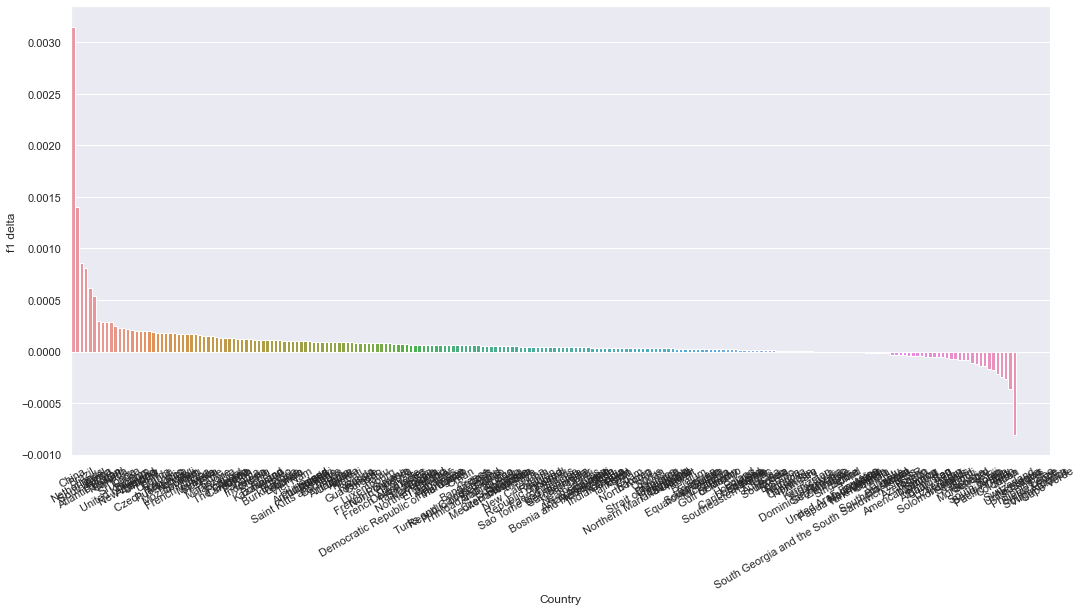

In [16]:
sns.set(rc={'figure.figsize':(17.55,8.27)})
ax = sns.barplot(x='Country', y='f1 delta', data=iclogo.sort_values(by='f1 delta', ascending=False))
l = ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

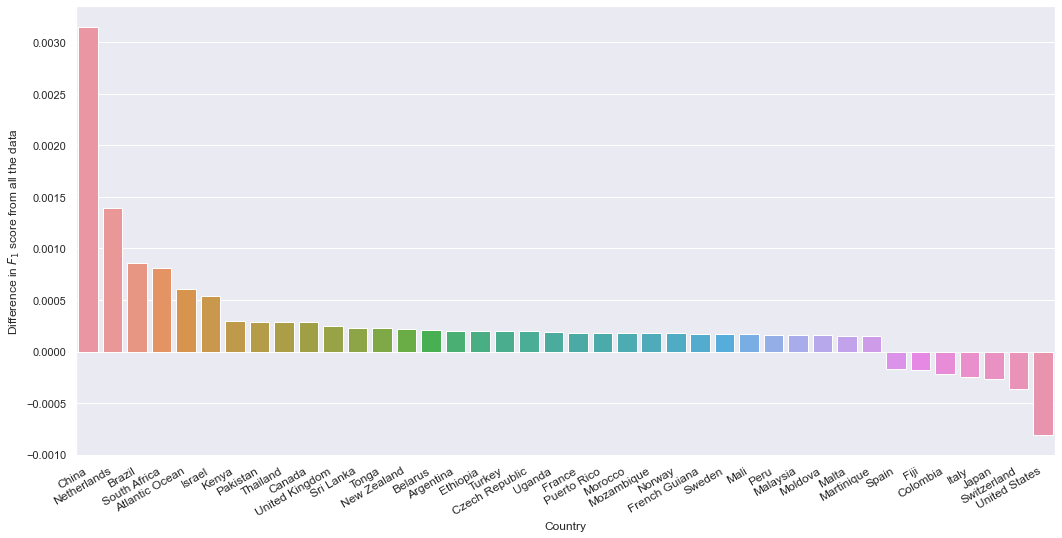

In [23]:
sns.set(rc={'figure.figsize':(17.55,8.27)})
iclogotop = iclogo[iclogo['f1 delta'].abs() > 0.00015].sort_values(by='f1 delta', ascending=False)
ax = sns.barplot(x='Country', y='f1 delta', data=iclogotop)
l = ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right', fontsize=12)
ax.set_ylabel("Difference in $F_1$ score from all the data")
plt.show()

In [27]:
iclogotop

,Code,Country,f1 delta,mean_phages,median_phages,sum_phages,std_phages,count_phages,min_phages,max_phages,mode_phages,var_phages
168,41,China,0.003151,4.418187,4.0,33428.0,3.257912,7566.0,0.0,74.0,4.0,10.613993
43,137,Netherlands,0.001397,2.917722,2.0,3227.0,3.039039,1106.0,0.0,22.0,1.0,9.235758
157,31,Brazil,0.000860,4.407650,4.0,8066.0,3.159674,1830.0,0.0,38.0,3.0,9.983539
97,186,South Africa,0.000809,3.672363,3.0,11175.0,2.974820,3043.0,0.0,34.0,2.0,8.849555
35,13,Atlantic Ocean,0.000612,0.892699,0.0,807.0,1.391555,904.0,0.0,9.0,0.0,1.936425
228,96,Israel,0.000535,3.823330,3.0,3376.0,2.523908,883.0,0.0,22.0,3.0,6.370113
5,102,Kenya,0.000295,3.782881,3.0,1812.0,2.738009,479.0,0.0,23.0,2.0,7.496694
59,151,Pakistan,0.000284,5.351351,5.0,2970.0,2.890444,555.0,0.0,25.0,4.0,8.354669
121,207,Thailand,0.000283,5.459860,5.0,7005.0,3.920493,1283.0,0.0,74.0,4.0,15.370267
162,36,Canada,0.000283,4.103215,3.0,14550.0,4.401892,3546.0,0.0,35.0,0.0,19.376650


No handles with labels found to put in legend.


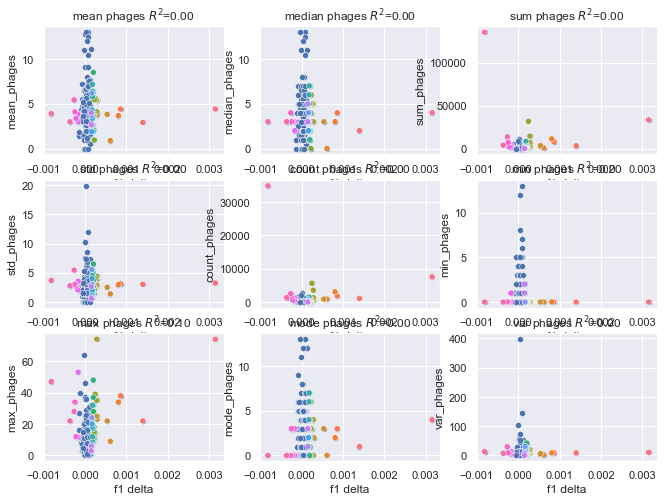

In [56]:
cols = [
        ['mean_phages', 'median_phages', 'sum_phages'],
        ['std_phages', 'count_phages', 'min_phages'], 
        ['max_phages', 'mode_phages', 'var_phages']
]

model = LinearRegression()

datalen = len(iclogo['f1 delta'])
x = iclogo['f1 delta'].fillna(0).values.reshape(datalen, 1)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(11, 8))

for i in 0,1,2:
    for j in 0,1,2:
        y = iclogo[cols[i][j]].fillna(0).values.reshape(datalen, 1)
        m = model.fit(x, y)        
        bx = sns.scatterplot(x='f1 delta', y=cols[i][j], data=iclogo, ax=ax[i][j])
        bx2 =  sns.scatterplot(x='f1 delta', y=cols[i][j], data=iclogotop, ax=ax[i][j], hue='Country')
        if 2==i and 0==j:
            # handles, labels = bx2.get_legend_handles_labels()
            plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)
        bx2.get_legend().remove()
        bx.set_title(f"{cols[i][j].replace('_', ' ')} $R^2$={m.score(x,y):.2f}")
#        

#fig.legend(handles, labels, loc='upper center')
#l = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#l = plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)
#
#plt.tight_layout()

# Category Importance

In [19]:
catgo = pd.read_csv('../data/Category_importance.tsv', delimiter="\t")
catgo = catgo[catgo['Category'].notnull()]

In [20]:
icc = pd.DataFrame(pd.unique(phagemeta['Category'])).set_index(0)
icc['mean_phages'] = phagemeta.groupby('Category').mean()['Kept']
icc['median_phages'] = phagemeta.groupby('Category').median()['Kept']
icc['sum_phages'] = phagemeta.groupby('Category').sum()['Kept']
icc['std_phages'] = phagemeta.groupby('Category').std()['Kept']
icc['count_phages'] = phagemeta.groupby('Category').count()['Kept']

icc['min_phages'] = phagemeta.groupby('Category').agg(['min'])['Kept']
icc['max_phages'] = phagemeta.groupby('Category').agg(['max'])['Kept']

icc['mode_phages'] = phagemeta.groupby('Category').agg(lambda x: mode(x)[0])['Kept']
icc['var_phages'] = phagemeta.groupby('Category').var()['Kept']

icc = icc.reset_index().rename({0:'Category'}, axis=1)
icc = icc[icc['Category'].notnull()]
icc

,Category,mean_phages,median_phages,sum_phages,std_phages,count_phages,min_phages,max_phages,mode_phages,var_phages
1,food,4.423434,4.0,11439.0,3.175787,2586.0,0.0,24.0,3.0,10.085625
2,soil,4.258083,3.0,14486.0,4.940320,3402.0,0.0,74.0,0.0,24.406764
3,human blood,3.983308,4.0,2625.0,2.408450,659.0,0.0,21.0,3.0,5.800633
4,human other,4.687385,4.0,22851.0,3.378696,4875.0,0.0,28.0,2.0,11.415588
5,animal,4.141327,3.0,13919.0,3.721953,3361.0,0.0,30.0,1.0,13.852937
6,hot spring,1.042272,0.0,789.0,1.656576,757.0,0.0,15.0,0.0,2.744242
7,plant,5.538183,5.0,16825.0,4.339520,3038.0,0.0,37.0,4.0,18.831436
8,human eye,3.720000,3.0,372.0,2.708311,100.0,0.0,11.0,2.0,7.334949
9,human gut,5.751394,5.0,51590.0,4.435733,8970.0,0.0,37.0,2.0,19.675728
10,fresh water,3.115385,1.0,4617.0,4.022831,1482.0,0.0,24.0,0.0,16.183166


In [35]:
iccatgo = pd.merge(catgo, icc, left_on='Category', right_on='Category', how='inner')
iccatgo

,Code,Category,f1 delta,mean_phages,median_phages,sum_phages,std_phages,count_phages,min_phages,max_phages,mode_phages,var_phages
0,0,air,6.432547e-05,2.212766,2.0,104.0,2.311937,47.0,0.0,8.0,0.0,5.345051
1,1,animal,7.374868e-04,4.141327,3.0,13919.0,3.721953,3361.0,0.0,30.0,1.0,13.852937
2,10,food,0.000000e+00,4.423434,4.0,11439.0,3.175787,2586.0,0.0,24.0,3.0,10.085625
3,11,fresh water,9.350159e-05,3.115385,1.0,4617.0,4.022831,1482.0,0.0,24.0,0.0,16.183166
4,12,fungus,1.763920e-05,7.125000,5.5,57.0,6.334430,8.0,2.0,21.0,2.0,40.125000
5,13,hot spring,6.720941e-04,1.042272,0.0,789.0,1.656576,757.0,0.0,15.0,0.0,2.744242
6,14,human blood,6.971278e-04,3.983308,4.0,2625.0,2.408450,659.0,0.0,21.0,3.0,5.800633
7,15,human bone,0.000000e+00,4.000000,4.0,8.0,2.828427,2.0,2.0,6.0,2.0,8.000000
8,16,human brain,2.183420e-05,4.808874,3.0,1409.0,4.853080,293.0,0.0,32.0,2.0,23.552387
9,17,human ear,3.819634e-06,3.457143,3.0,242.0,2.711680,70.0,0.0,14.0,1.0,7.353209


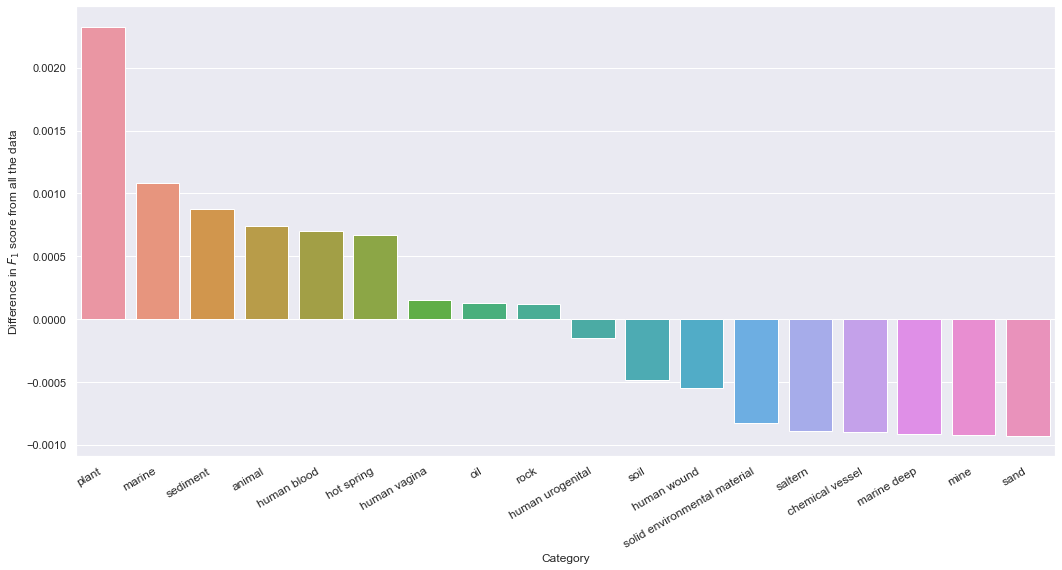

In [38]:
sns.set(rc={'figure.figsize':(17.55,8.27)})
iccatgotop = iccatgo[iccatgo['f1 delta'].abs() > 0.0001].sort_values(by='f1 delta', ascending=False)
ax = sns.barplot(x='Category', y='f1 delta', data=iccatgotop)
l = ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right', fontsize=12)
ax.set_ylabel("Difference in $F_1$ score from all the data")
plt.show()

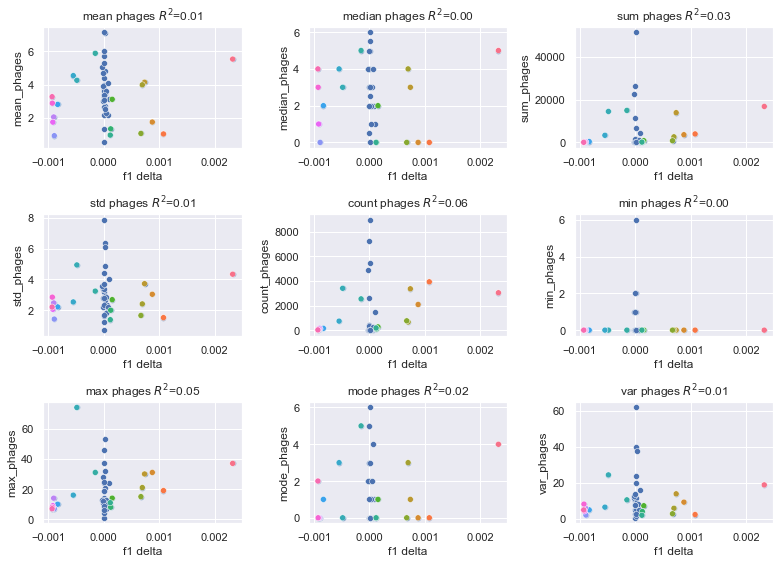

In [40]:
cols = [
        ['mean_phages', 'median_phages', 'sum_phages'],
        ['std_phages', 'count_phages', 'min_phages'], 
        ['max_phages', 'mode_phages', 'var_phages']
]

model = LinearRegression()

datalen = len(iccatgo['f1 delta'])
x = iccatgo['f1 delta'].fillna(0).values.reshape(datalen, 1)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(11, 8))

for i in 0,1,2:
    for j in 0,1,2:
        y = iccatgo[cols[i][j]].fillna(0).values.reshape(datalen, 1)
        m = model.fit(x, y)        
        bx = sns.scatterplot(x='f1 delta', y=cols[i][j], data=iccatgo, ax=ax[i][j])
        bx = sns.scatterplot(x='f1 delta', y=cols[i][j], data=iccatgotop, ax=ax[i][j], hue='Category', legend=False)
        bx.set_title(f"{cols[i][j].replace('_', ' ')} $R^2$={m.score(x,y):.2f}")

plt.tight_layout()